Beata Sirowy

# A Machine Learning project: 
# California Housing Prices

Based on:
Geron, A. (2023) _Hands-On Machine Learning
with Scikit-Learn, Keras, and TensorFlow_ 

Liu, Y. (2020) _Python Machine Learning By Example_


Popular open data repositories for ML projects include:
- OpenML.org
- Kaggle.com
- PapersWithCode.com
- UC Irvine Machine Learning Repository
- Amazon’s AWS datasets
- TensorFlow datasets

Meta portals (they list open data repositories):
- DataPortals.org
- OpenDataMonitor.eu

Other pages listing many popular open data repositories:

- Wikipedia’s list of machine learning datasets
- Quora.com
- The datasets subreddit


## The task

We’ll use the California Housing Prices dataset from the
StatLib repository. This dataset is based on data from the
1990 California census.

Our first task is
- to use California census data to build a model of housing prices in the state.

Our data includes metrics such as the population, median income, and
median housing price for each block group in California. 

Block groups are
the smallest geographical unit for which the US Census Bureau publishes
sample data (a block group typically has a population of 600 to 3,000
people). We will call them “districts” for short.

- Our model should learn from this data and be able to predict the median
housing price in any district, given all the other metrics.

### Framing the problem

#### __1. How does the company expect to use and benefit from this model?__
- the model’s output (a prediction of a district’s
median housing price) will be fed to another machine learning system (see
Figure 2-2), along with many other signals
- this downstream system will
determine whether it is worth investing in a given area 
- getting this right is
critical, as it directly affects revenue.


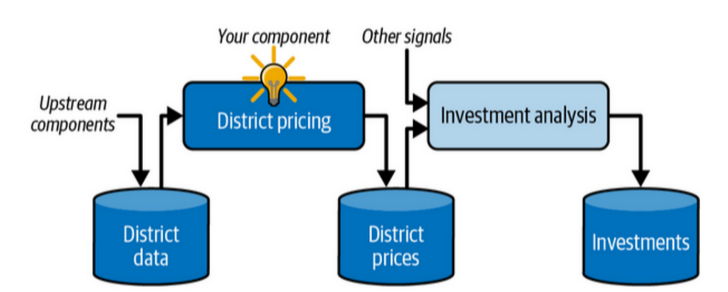

__A data pipeline:__ a sequence of data processing components 
- Pipelines are very common in machine learning systems, since there is
a lot of data to manipulate and many data transformations to apply.
- omponents typically run asynchronously. 
- Each component pulls in a
large amount of data, processes it, and spits out the result in another
data store. 
- Then, some time later, the next component in the pipeline
pulls in this data and spits out its own output. 
- Each component is fairly
self-contained: the interface between components is simply the data
store. 
- This makes the system simple to grasp (with the help of a data
flow graph), and different teams can focus on different components.
- If a component breaks down, the downstream components
can often continue to run normally (at least for a while) by just using
the last output from the broken component. This makes the architecture
quite robust.
- On the other hand, a broken component can go unnoticed for some time
if proper monitoring is not implemented. The data gets stale and the
overall system’s performance drops.

#### __2. What the current solution looks like (if any).__

- the
district housing prices are currently estimated manually by experts:
- a team
gathers up-to-date information about a district, and when they cannot get
the median housing price, they estimate it using complex rules.
- this is costly and time-consuming, and their estimates are not great; in
cases where they manage to find out the actual median housing price, they
often realize that their estimates were off by more than 30%.

#### __3. Designing the system__
- supervised, unsupervised, semi-supervised, self-supervised, or
reinforcement learning task? 
- a classification task, a regression
task, or something else? 
- batch learning or online learning
techniques?

This is clearly a typical __supervised
learning__ task, since the model can be trained with labeled examples (each
instance comes with the expected output, i.e., the district’s median housing
price). 

It is a typical regression task, since the model will be asked to
predict a value. 
- More specifically, this is __a multiple regression problem__,
since the system will use multiple features to make a prediction.
- It is also a univariate
regression problem, since we are only trying to predict a single value for
each district. 
- If we were trying to predict multiple values per district, it
would be a multivariate regression problem.

There is no continuous
flow of data coming into the system, there is no particular need to adjust to
changing data rapidly, and the data is small enough to fit in memory, so
plain __batch learning__ should do just fine.

If the data were huge, you could either split your batch learning work across multiple
servers (using the MapReduce technique) or use an online learning technique.

#### __4. Select a Performance Measure__

A typical performance
measure for regression problems is the __root mean square error (RMSE)__. 

It
gives an idea of how much error the system typically makes in its
predictions, with a higher weight given to large errors.

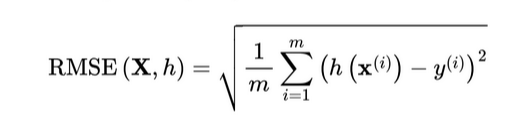

- m is the number of instances in the dataset you are measuring the
RMSE on.
- x(i) is a vector of all the feature values (excluding the label) of the
i instance in the dataset, 
-y(i) is its label (the desired output
value for that instance).

For example, if the first district in the dataset is located at
longitude –118.29°, latitude 33.91°, and it has 1,416
inhabitants with a median income of $38,372, and the median
house value is $156,400 (ignoring other features for now),
then:

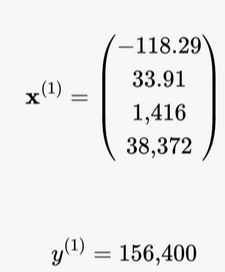

For a district, we have a matrix X:

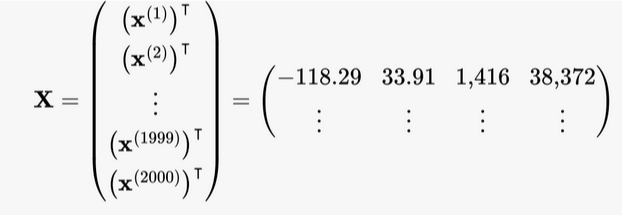

h is your system’s prediction function, also called a hypothesis.
- when your system is given an instance’s feature vector x(i) , it
outputs a predicted value ŷ(i) = h(x(i) ) for that instance (ŷ is
pronounced “y-hat”).

For example, if your system predicts that the median housing
price in the first district is $158,400, then ŷ(1) = h(x(1) ) =
158,400. The prediction error for this district is ŷ(1) – y(1) =
2,000.

RMSE(X,h) is the cost function measured on the set of examples
using your hypothesis h.


We use:  
- lowercase italic font for scalar values (such as _m_ or _y(i)_ ) and
function names (such as _h_), 
- lowercase bold font for vectors (such as
__x__ ), 
- uppercase bold font for matrices (such as __X__).






Although the RMSE is generally the preferred performance measure for
regression tasks, in some contexts you may prefer to use another function.
- For example, if there are many outlier districts. In that case, you may
consider using the __mean absolute error__ (MAE, also called the average
absolute deviation),

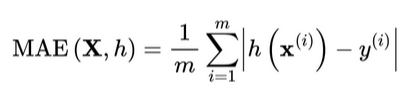

Both the RMSE and the MAE are ways to measure __the distance between
two vectors: the vector of predictions and the vector of target values__.

Computing the root of a sum of squares __(RMSE)__ corresponds to the
__Euclidean norm__ (l2 norm): this is the notion of distance we are all familiar with.

Computing the sum of absolutes __(MAE)__ corresponds to the l1 norm,
noted. This is sometimes called the __Manhattan norm__ because it
measures the distance between two points in a city if you can only
travel along orthogonal city blocks.

The higher the norm index, the more it focuses on large values and neglects
small ones. 
- This is why the __RMSE is more sensitive to outliers__ than the
MAE. 
- But when outliers are exponentially rare (like in a bell-shaped curve),
the __RMSE performs very well and is generally preferred__.

#### __5. Check the Assumptions__
Lastly, it is good practice to list and verify the assumptions that have been
made so far (by you or others).

For example, the district prices that your system outputs are going to be
fed into a downstream machine learning system, and you assume that these
prices are going to be used as such. 

But what if the downstream system
converts the prices into categories (e.g., “cheap”, “medium”, or
“expensive”) and then uses those categories instead of the prices
themselves? 

In this case, getting the price perfectly right is not important at
all; your system just needs to get the category right. If that’s so, then the
problem should have been framed as a classification task, not a regression task.

## Get the data


In [7]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing["housing_median_age"].value_counts()

housing_median_age
52.0    1273
36.0     862
35.0     824
16.0     771
17.0     698
34.0     689
26.0     619
33.0     615
18.0     570
25.0     566
32.0     565
37.0     537
15.0     512
19.0     502
27.0     488
24.0     478
30.0     476
28.0     471
20.0     465
29.0     461
31.0     458
23.0     448
21.0     446
14.0     412
22.0     399
38.0     394
39.0     369
42.0     368
44.0     356
43.0     353
40.0     304
13.0     302
41.0     296
45.0     294
10.0     264
11.0     254
46.0     245
5.0      244
12.0     238
8.0      206
9.0      205
47.0     198
4.0      191
48.0     177
7.0      175
6.0      160
50.0     136
49.0     134
3.0       62
2.0       58
51.0      48
1.0        4
Name: count, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


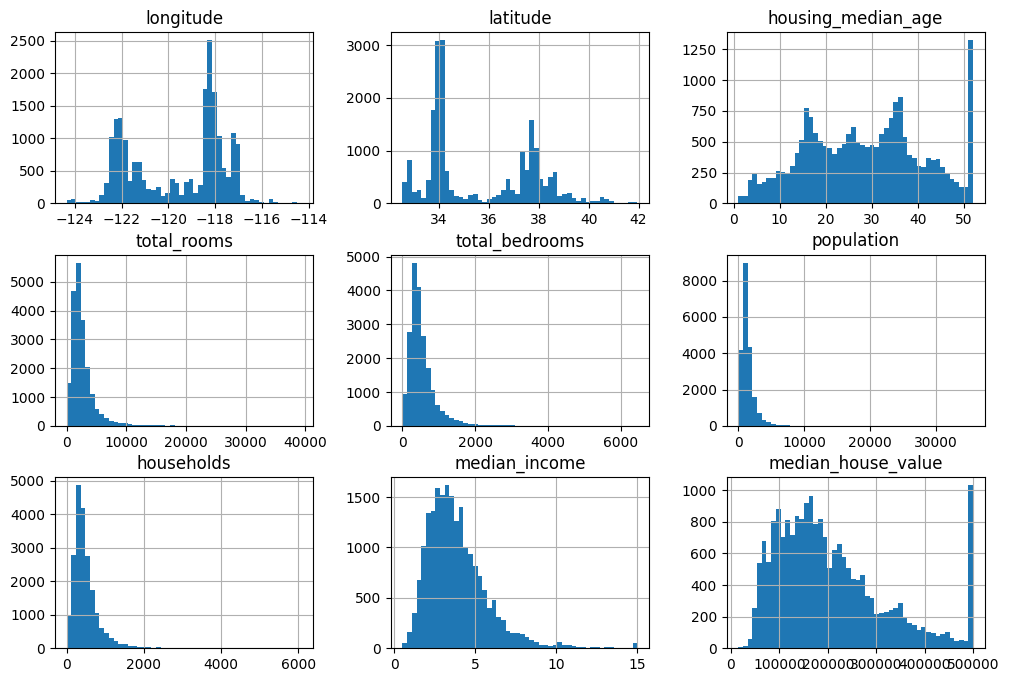

In [9]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(12, 8))
plt.show()

Looking at these histograms, we notice a few things:

1.  The median income attribute does not look like it is expressed in
US dollars (USD). 
- After checking with the team that collected the
data, you are told that the data has been scaled and capped at 15
(actually, 15.0001) for higher median incomes, and at 0.5 (actually,
0.4999) for lower median incomes.
-  The numbers represent roughly
tens of thousands of dollars (e.g., 3 actually means about $30,000).
- Working with preprocessed attributes is common in machine learning,
and it is not necessarily a problem, but you should try to understand
how the data was computed.

2. The housing median age and the median house value were also
capped. The latter may be a serious problem since it is your target
attribute (your labels). Your machine learning algorithms may learn
that prices never go beyond that limit.
- You need to check with your
client team (the team that will use your system’s output) to see if this is a problem or not. 
- If they tell you that they need precise predictions
even beyond $500,000, then you have two options:
a) Collect proper labels for the districts whose labels were capped.
b) Remove those districts from the training set (and also from the
test set, since your system should not be evaluated poorly if it
predicts values beyond $500,000).


3. These attributes have very different scales. We will discuss this later when we explore feature scaling.

4. Many histograms are skewed right: they extend much farther to
the right of the median than to the left. This may make it a bit harder
for some machine learning algorithms to detect patterns. 
- Later, we’ll try transforming these attributes to have more symmetrical and bell-
shaped distributions.




### Create a Test Set

__Before you look at the data any further, you need to create a test set, put it aside,
and never look at it.__

- your brain is an amazing pattern detection
system, which also means that it is __highly prone to overfitting:__ if you look
at the test set, you may stumble upon some seemingly interesting pattern in
the test data that leads you to select a particular kind of machine learning
model. 
- When you estimate the generalization error using the test set, your estimate will be too optimistic, and you will launch a system that will not
perform as well as expected. This is called __data snooping bias__.


__Generalization error__ (or out-of-sample error) -  the error rate on new cases, We estimate it by evaluating our model
on the test set. This value tells you how
well your model will perform on instances it has never seen before.
- If the training error is low (i.e., your model makes few mistakes on the
training set) but the generalization error is high, it means that your model is
overfitting the training data.

__Creating a test set__ 
- pick some instances randomly,
typically 20% of the dataset (or less if your dataset is very large), and set
them aside:

In [9]:
import numpy as np
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

len(train_set)

16512

In [13]:
len(test_set)

4128

This works, but it is not perfect: 
- if you run the program again, it will
generate a different test set! 

Over time, you (or your machine learning
algorithms) will get to see the whole dataset, which is what you want to
avoid.

One solution is to save the test set on the first run and then load it in
subsequent runs. 
- Another option is to set the random number generator’s
seed (e.g., with np.random.seed(42)) before calling
np.random.permutation() so that it always generates the same shuffled
indices.

However, both these solutions will break the next time you fetch an updated
dataset. 

To have a stable train/test split even after updating the dataset, a
common solution is to use each instance’s identifier to decide whether or
not it should go in the test set (assuming instances have unique and
immutable identifiers). 
- For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower
than or equal to 20% of the maximum hash value. 
- This ensures that the test
set will remain consistent across multiple runs, even if you refresh the
dataset. 
- The new test set will contain 20% of the new instances, but it will
not contain any instance that was previously in the training set.

Here is a possible implementation:

In [10]:
from zlib import crc32


def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The
simplest solution is to use the row index as the ID:

In [11]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that
new data gets appended to the end of the dataset and that no row ever gets
deleted. 

If this is not possible, then you can try to use the most stable
features to build a unique identifier. For example, a district’s latitude and
longitude are guaranteed to be stable for a few million years, so you could
combine them into an ID like so:

In [12]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Scikit-Learn provides a few functions to split datasets into multiple subsets
in various ways. 

The simplest function is __train_test_split()__, which
does pretty much the same thing as the shuffle_and_split_data()
function we defined earlier, with a couple of additional features
- there is a random_state parameter that allows you to set the random generator
seed
- you can pass it multiple datasets with an identical number of
rows, and it will split them on the same indices (this is very useful, for
example, if you have a separate DataFrame for labels)

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=4242)

__Stratified sampling__

Random sampling is generally fine if your dataset is large enough (especially relative to the
number of attributes), but if it is not, you run the risk of introducing a
significant __sampling bias.__ 

__Stratified sampling__: the population is divided into homogeneous subgroups
called strata, and the right number of instances are sampled from each
stratum to guarantee that the test set is representative of the overall
population. 

For example, the US population is 51.1%
females and 48.9% males. If the people running the survey used purely random sampling,
there would be about a 10.7% chance of sampling a skewed test set with
less than 48.5% female or more than 53.5% female participants. Either way,
the survey results would likely be quite biased.

Suppose you’ve chatted with some experts who told you that the median
income is a very important attribute to predict median housing prices. 
- You
may want to ensure that the test set is representative of the various
categories of incomes in the whole dataset. 
- Since the median income is a
continuous numerical attribute, you first need to create __an income category
attribute__.

Most median income values are clustered around 1.5 to 6 ($15,000–$60,000), but some median incomes go far beyond 6.

It is
important to have a __sufficient number of instances__ in your dataset for each
stratum, or else the estimate of a stratum’s importance may be biased. 
- This
means that you should not have too many strata, and each stratum should be
large enough. 

The following code uses the pd.cut() function to create an
income category attribute with five categories (labeled from 1 to 5);
category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5
to 3, and so on:

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"],

bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

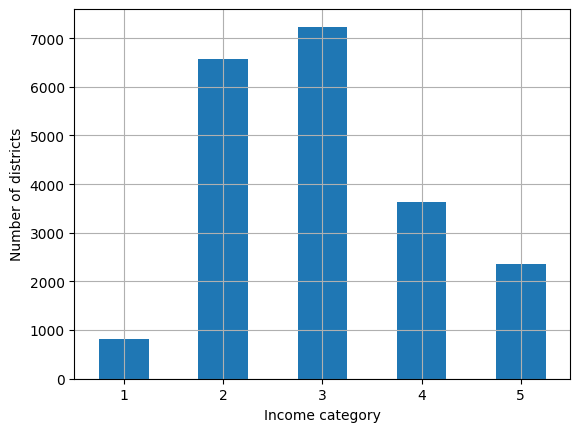

In [15]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Now you are ready to do stratified sampling based on the income category.
- Scikit-Learn provides a number of splitter classes in the
sklearn.model_selection package that implement various strategies to
split your dataset into a training set and a test set. 
- Each splitter has a
split() method that returns an iterator over different training/test splits of
the same data.
- To be precise, the split() method yields the training and test indices, not
the data itself. Having multiple splits can be useful if you want to better
estimate the performance of your model, as you will see when we discuss
__cross-validation__. 
- For example, the following code
generates 10 different __stratified splits__ of the same dataset:

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=4242)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

For now, we can just use the first split:

In [17]:
strat_train_set, strat_test_set = strat_splits[0]

Since stratified sampling is fairly common, there’s a shorter way to get a
single split using the __train_test_split()__ function with the stratify
argument:

In [ ]:
strat_train_set, strat_test_set = train_test_split(
housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

Let’s see if this worked as expected. We can start by looking at the income
category proportions in __the stratified test set__:

In [31]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

The income
category proportions in __the random test set__:

In [39]:
test_set["income_cat"].value_counts() / len(test_set)

income_cat
3    0.352713
2    0.313711
4    0.184351
5    0.109254
1    0.039971
Name: count, dtype: float64

With similar code you can measure the income category proportions in __the
full dataset__. 


In [38]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64



The following figure compares the income category proportions in the
overall dataset, in the test set generated with stratified sampling, and in a
test set generated using purely random sampling.
As you can see, the test
set generated using stratified sampling has income category proportions
almost identical to those in the full dataset, whereas the test set generated
using purely random sampling is skewed.

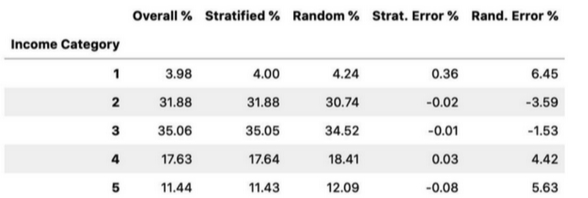

We won’t use the income_cat column again, so we might as well drop it,
reverting the data back to its original state:


In [ ]:
for n in (strat_train_set, strat_test_set):
    n.drop("income_cat", axis=1, inplace=True)

__Test set generation  is
an often neglected but critical part of a machine learning project.__

## Explore and Visualize the Data to Gain Insights

- First, make sure you have put the test set aside and you are only exploring
the training set.  
- If the training set is very large, you may want to
sample an exploration set, to make manipulations easy and fast during the
exploration phase. 
- In this case, the training set is quite small, so you can
just work directly on the full set. 
- Since you’re going to experiment with
various transformations of the full training set, you should make a copy of
the original so you can revert to it afterwards:

In [18]:
housing = strat_train_set.copy()

#### Visualizing Geographical Data

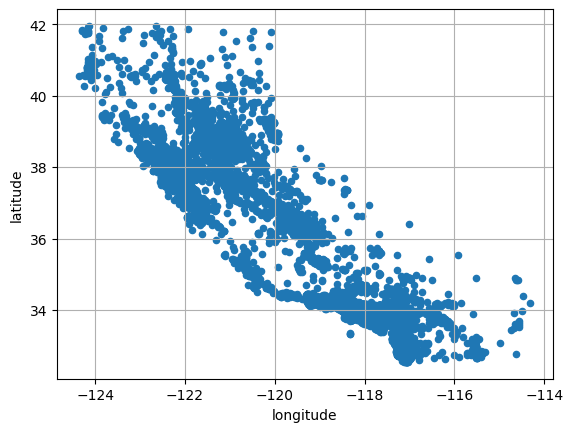

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

Adding a background map, setting the alpha to 0.2

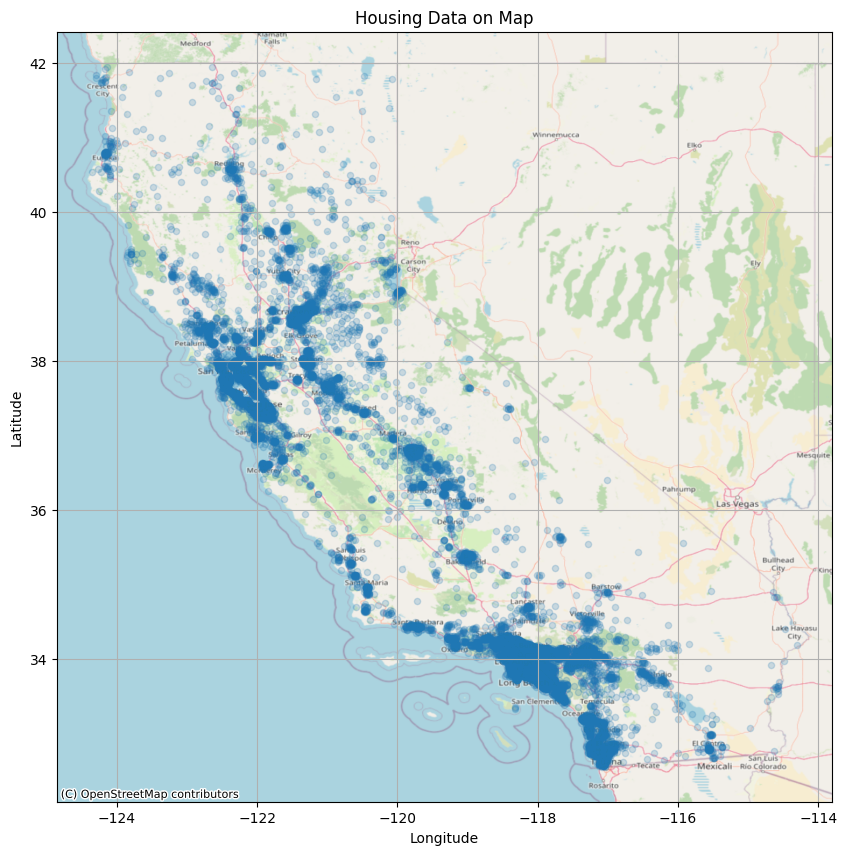

In [23]:
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt 
import contextily as ctx 


# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(housing, geometry=gpd.points_from_xy(housing.longitude, housing.latitude))

# Set the CRS to WGS 84 (EPSG:4326) which is a common geographic coordinate system.
gdf.set_crs(epsg=4326, inplace=True)

# Plot the data
ax = gdf.plot(kind="scatter", x="longitude", y="latitude", grid=True, figsize=(10, 10), alpha=0.2)

# Add the map
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

plt.xlabel("Longitude") 
plt.ylabel("Latitude") 
plt.title("Housing Data on Map")

plt.show()


Example of Zoom Levels and Scale in basemap

- Zoom 0: World view (very low detail).

- Zoom 5: Continent level.

- Zoom 10: City level.

- Zoom 12: Neighborhood level (more detailed, showing streets and smaller features).

- Zoom 18: Building level (very high detail, showing individual buildings and points of interest).

Next, we look at the housing prices . The radius of each circle
represents the district’s population (option s), and the color represents the
price (option c). Here you use a predefined color map (option cmap) called
jet, which ranges from blue (low values) to red (high prices):

<Axes: xlabel='longitude', ylabel='latitude'>

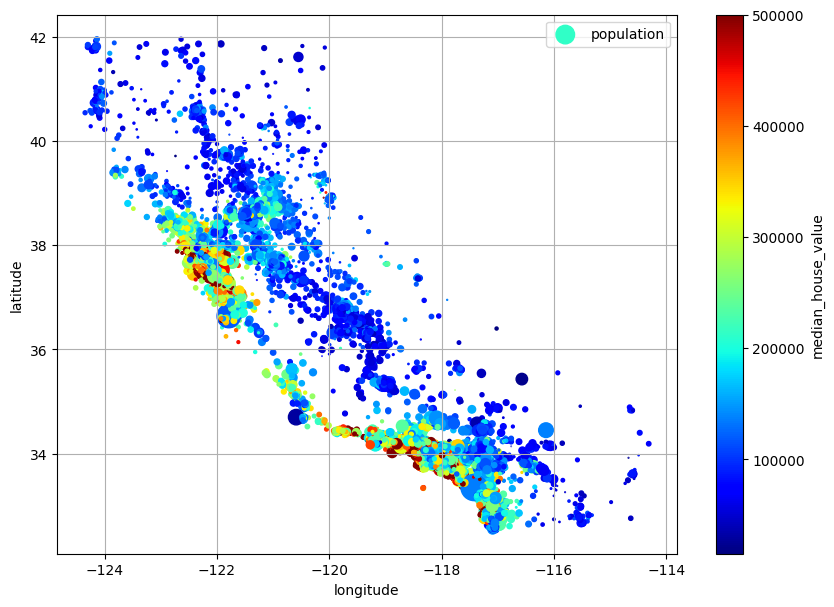

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=housing["population"] / 100, label="population",
c="median_house_value", cmap="jet", colorbar=True,
legend=True, sharex=False, figsize=(10, 7))


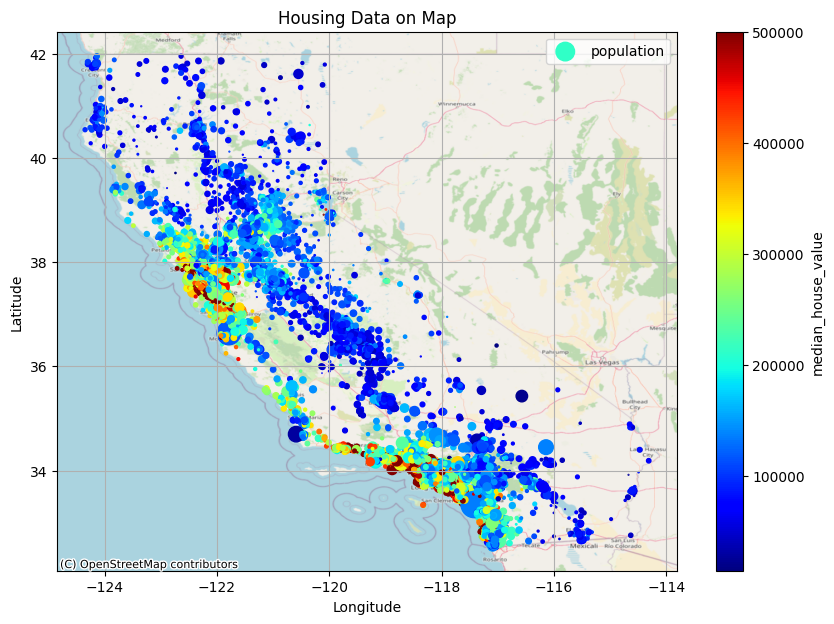

In [28]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(housing, geometry=gpd.points_from_xy(housing.longitude, housing.latitude))

# Set the CRS to WGS 84 (EPSG:4326) which is a common geographic coordinate system.
gdf.set_crs(epsg=4326, inplace=True)


ax = gdf.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=housing["population"] / 100, label="population",
c="median_house_value", cmap="jet", colorbar=True,
legend=True, sharex=False, figsize=(10, 7))

ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

plt.xlabel("Longitude") 
plt.ylabel("Latitude") 
plt.title("Housing Data on Map")

plt.show()

This image tells us  that the housing prices are very much related to the
location (e.g., close to the ocean) and to the population density. 
- A clustering algorithm should be useful for
detecting the main cluster and for adding new features that measure the
proximity to the cluster centers. 
- The ocean proximity attribute may be
useful as well, although in Northern California the housing prices in coastal
districts are not too high, so it is not a simple rule.

#### Handling Text and Categorical Attributes

In this dataset, there is just one text attribute: the
ocean_proximity attribute.

In [32]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
6810,INLAND
10121,INLAND
18336,NEAR OCEAN
14529,INLAND
7103,NEAR OCEAN
14050,NEAR BAY
883,<1H OCEAN
18394,INLAND


It’s not arbitrary text: there are a limited number of possible values, each of
which represents a category. So this attribute is a categorical attribute. 
- Most
machine learning algorithms prefer to work with numbers, so let’s convert
these categories from text to numbers. 
- For this, we can use Scikit-Learn’s
OrdinalEncoder class:

In [34]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:8]

array([[1.],
       [1.],
       [4.],
       [1.],
       [4.],
       [3.],
       [0.],
       [1.]])

In [35]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that
two nearby values are more similar than two distant values. 
- This may be
fine in some cases (e.g., for ordered categories such as “bad”, “average”,
“good”, and “excellent”), but it is obviously not the case for the
ocean_proximity column (for example, categories 0 and 4 are clearly
more similar than categories 0 and 1). 
- To fix this issue, a common solution
is to create one binary attribute per category: one attribute equal to 1 when
the category is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1
when the category is "INLAND" (and 0 otherwise), and so on. 
- This is called
one-hot encoding, because only one attribute will be equal to 1 (hot), while
the others will be 0 (cold). The new attributes are sometimes called dummy
attributes. 
- Scikit-Learn provides a OneHotEncoder class to convert
categorical values into one-hot vectors:

In [37]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

A sparse matrix is a very efficient representation for matrices that contain
mostly zeros. Internally it only stores the nonzero values and their
positions. 
If you want to
convert it to a (dense) NumPy array, call the toarray() method:

In [38]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

Alternatively, you can set sparse=False when creating the
OneHotEncoder, in which case the transform() method will return a
regular (dense) NumPy array directly.

Pandas has a function called get_dummies(), which also converts each
categorical feature into a one-hot representation, with one binary feature per
category:

In [39]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


__The advantage of OneHotEncoder__ is that it remembers which
categories it was trained on. This is very important because once your
model is in production, it should be fed exactly the same features as during
training: no more, no less.

Look what our trained cat_encoder outputs
when we make it transform the same df_test (using transform(), not
fit_transform()):

In [43]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

- get_dummies() saw only two categories, so it output
two columns, whereas OneHotEncoder output one column per learned
category, in the right order. 
- moreover, if you feed get_dummies() a
DataFrame containing an unknown category (e.g., "<2H OCEAN"), it will
happily generate a column for it
- OneHotEncoder is smarter: it will detect the unknown category and
raise an exception.

#### Look for Correlations
Since the dataset is not too large, we can easily compute the standard
correlation coefficient (also called Pearson’s r) between every pair of
attributes using the corr() method:

In [44]:
corr_matrix = housing.corr()

ValueError: could not convert string to float: 'INLAND'

In [30]:
corr_matrix["median_house_value"].sort_values(ascending=False)

NameError: name 'corr_matrix' is not defined